In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import chromedriver_autoinstaller

import time
import random
import subprocess
from datetime import datetime
import missingno as ms
from plotnine import *

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

## Contents:
- Set Selenium options
- Scrape OddsPortal URLs of all NBA Games in a season [saved to .txt file]
- Scrape Bookmaker data from OP URLs into dataframe [saved to pickle]
- Transform Bookmaker dataframe
- Join NBA team identifiers (needed to join to RAPTOR)
- Join RAPTOR scores downloaded from 538

### Set Selenium Options 
Important! so that OddsPortal is signed in to Sam's account

In [36]:
profile_path = r'C:\Users\sleblanc\AppData\Local\Google\Chrome\User Data'
profile_name = 'Profile 3'

In [37]:
def set_chrome_options():
    """
    Set options for the Chrome webdriver used by Selenium.
    Most importantly, set the user data directory and user profile to utilize Chrome's saved passwords.
    ----------------
    Returns: webdriver.ChromeOptions: Configured Chrome webdriver options.
    """
    profile_path = r'C:\Users\sleblanc\AppData\Local\Google\Chrome\User Data'
    profile_name = 'Profile 3'
    options = webdriver.ChromeOptions()
    options.add_argument(f'user-data-dir={profile_path}')
    options.add_argument(f'--profile-directory={profile_name}')
    return options


def kill_chrome_processes():
    """
    Terminate all running Chrome processes.
    Selenium may encounter issues if there are multiple Chrome instances running,
    especially when using a Chrome profile for saved passwords. This function
    terminates all Chrome processes (using the subprocess module), including
    previous Selenium instances.
    """
    subprocess.call("TASKKILL /f  /IM  CHROME.EXE", stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)


def get_webdriver():
    """
    Instantiate and return a Selenium Chrome webdriver with custom options.
    ----------------
    Returns:
        webdriver.Chrome: Configured Chrome webdriver instance.
        False if an exception occurs during instantiation.
    Note:
        The webdriver must be downloaded and added to PATH. See:
        https:/selenium-python.readthedocs.io/installation.html
    """
    try:
        chromedriver_autoinstaller.install()
        kill_chrome_processes()
        options = set_chrome_options()
        driver = webdriver.Chrome(options=options)
        return driver
    except Exception as e:
        print(e)
        return False

## Scrape OddsPortal URLs of All NBA Games in a Season
Done: [saved to .txt file]

In [38]:
def load_page(driver, retries=5):
    """
    Load the content of a page by scrolling to the bottom multiple times.
    ----------------
    Args:
        driver (webdriver): The Selenium webdriver instance to interact with the page.
        retries (int, optional): The number of times to scroll to the bottom. Defaults to 5.
    """
    for _ in range(retries):
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

def extract_game_hrefs(driver, season, remove_hrefs):
    """
    Extract the game links from the current page of the NBA season results.
    ----------------
    Args:
        driver (webdriver): The Selenium webdriver instance to interact with the page.
        season (str): The NBA season in the format "YYYY-YYYY".
        remove_hrefs (list): A list of URLs to exclude from the result.
    Returns:
        set: A set of URLs for individual games in the specified NBA season.
    """
    hrefs = [x.get_attribute("href") for x in driver.find_elements_by_tag_name("a")]
    if season == '2022-2023':
        game_hrefs = set(x for x in hrefs if '/basketball/usa/nba/' in x and x not in remove_hrefs)
    else:
        game_hrefs = set(x for x in hrefs if f'nba-{season}' in x and x not in remove_hrefs)
    return game_hrefs


def click_next_page(driver):
    """
    Click the "Next" button to navigate to the next page of the NBA season results.
    ----------------
    Args: driver (webdriver): The Selenium webdriver instance to interact with the page.
    Raises: Exception: If the "Next" button is not found on the page.
    """
    driver.find_elements_by_class_name("h-max")[1].click()


def scrape_season(season, max_pages=30):
    """
    Scrape game links from the NBA season results page on OddsPortal.
    ----------------
    Args:
        season (str, optional): The NBA season to scrape. Defaults to "2021-2022".
        max_pages (int, optional): Maximum number of pages to scrape. Defaults to 30.
    Returns:
        list: A list of URLs for individual games in the specified NBA season.
    """
    all_game_urls = set()
    url_base = "https://www.oddsportal.com/basketball/usa/"
    
    if season == '2022-2023':
        url = f"{url_base}nba/results/#"
    else:
        url = f"{url_base}nba-{season}/results/#"
        
    driver = get_webdriver()
    driver.get(url)

    for n in range(1, max_pages + 1):    
        time.sleep(0.5 + 2 * random.random())
        load_page(driver)

        remove_hrefs = [
            f'https://www.oddsportal.com/basketball/usa/nba-{season}/results/#',
            f'https://www.oddsportal.com/basketball/usa/nba-{season}/results/',
            f'https://www.oddsportal.com/basketball/usa/nba-{season}/',
            f'https://www.oddsportal.com/basketball/usa/nba-{season}/standings/',
            f'https://www.oddsportal.com/basketball/usa/nba/results/#',
            f'https://www.oddsportal.com/basketball/usa/nba/results/',
            f'https://www.oddsportal.com/basketball/usa/nba/',
            f'https://www.oddsportal.com/basketball/usa/nba/standings/',
        ]

        game_urls = extract_game_hrefs(driver, season, remove_hrefs)
        all_game_urls.update(game_urls)

        print(f'Page {n} Finished: Added {len(game_urls)} new games. Total Games: {len(all_game_urls)}')
                
        try:
            click_next_page(driver)
        except Exception as e:
            print(f"Next Page Error; closing driver")
            driver.quit()
            return list(all_game_urls)

    driver.quit()
    return list(all_game_urls)

## Scrape 🥷

In [39]:
# for season in ['2018-2019','2019-2020','2020-2021','2021-2022','2022-2023']:
    
#     print(f"\n {season} \n")

#     all_game_urls = scrape_season(season)

#     # save url list to text file for later
#     with open(f'all_game_urls_{season}.txt', 'w') as file:
#         for item in all_game_urls:
#             file.write(item + '\n')

## Create Bookmaker dataframes from OP URLs

In [40]:
def game_to_df(driver, game_info_xpath, odds_xpath):
    """
    Extract game and odds information from a webpage and return it as a DataFrame.
    ----------------
    Args:
        driver (WebDriver): Selenium WebDriver instance.
        game_info_xpath (str): XPath for the game information element.
        odds_xpath (str): XPath for the odds information element.
    Returns: 
        pd.DataFrame: DataFrame containing game and odds information.
    """

    def get_game_info():
        """
        Extract game information from the webpage using the given XPath.
        ----------------
        Returns: dict: Dictionary containing game information.
        """
        game_info_el = driver.find_element(By.XPATH, game_info_xpath)
        game_info_list = game_info_el.text.split('\n')

        format_string = '%A, %d %b %Y, %H:%M'
        game_time = game_info_list[5]

        return {
            'Game_Time' : datetime.strptime(game_time, format_string).strftime('%Y-%m-%d %H:%M'),
            'Home_Name' : game_info_list[0],
            'Away_Name' : game_info_list[3],
            'Game_Result' : game_info_list[7],
            'Home_Score' : game_info_list[1],
            'Away_Score' : game_info_list[4],
        }

    def get_odds_info():
        """
        Extract odds information from the webpage using the given XPath.
        ----------------
        Returns: list: List containing odds information.
        """
        odds_el = driver.find_element(By.XPATH, odds_xpath)

        odds_list = odds_el.text.split('\n')
        odds_list = [x for x in odds_list if x != 'BONUS']
        odds_list = odds_list[4:odds_list.index('Average')]

        return odds_list

    def get_odds_array(odds_list):
        """
        Convert the odds list into a NumPy array.
        ----------------
        Args: odds_list (list): List containing odds information.
        Returns: np.array: NumPy array of odds information, or False if the list length is not divisible by 4.
        """
        if len(odds_list) % 4 == 0:
            rows = int(len(odds_list) / 4)
            odds_array = np.array(odds_list).reshape(rows, 4)
            return odds_array
        else:
            return False

    # get the game info and odds
    try:
        game_summary = get_game_info()    
        odds_list = get_odds_info()    
        odds_array = get_odds_array(odds_list)

        # create dataframe of bookmaker odds 
        df = pd.DataFrame(odds_array, columns=['Bookmaker', 'Home_Amer', 'Away_Amer', 'Full_Payout'])

        # set the game summary values for all bookmaker rows in dataframe
        for key in game_summary:
            df[key] = game_summary[key]

        # reorder dataframe columns
        df = df[[
            'Game_Time', 'Home_Name', 'Away_Name', 'Game_Result', 'Home_Score', 'Away_Score',
            'Bookmaker', 'Home_Amer', 'Away_Amer', 'Full_Payout']]

        return df
    except:
        return pd.DataFrame()

## Scrape 🥷

In [42]:
bookmaker.shape

(4238, 10)

In [43]:
# load url list from file

all_game_urls = []

for season in ['2019-2020','0']:
    
    print(f"\n {season} \n")

    with open(f'all_game_urls_{season}.txt', 'r') as file:
        all_game_urls = [line.strip() for line in file.readlines()]
        
    print(f"\n {len(all_game_urls)} games \n")

    # Element XPATHs, subject to change
    game_info_xpath = "/html/body/div[1]/div/div[1]/div/main/div[2]/div[3]"
    odds_xpath = "/html/body/div[1]/div/div[1]/div/main/div[2]/div[4]"

    driver = get_webdriver()
    bookmaker = pd.DataFrame()
    i = 190
    for url in all_game_urls[190:]:
        if i % 10 == 0: print(f"Finished scraping {i} games out of {len(all_game_urls)}")

        # Scrape Home/Away odds data
        driver.get(url + '/#home-away;1')

        # Random sleep so no DDOS
        time.sleep(1 + 2*random.random())

        # Get bookmaker data from single game into dataframe
        df_ = game_to_df(driver, game_info_xpath, odds_xpath)

        i += 1
        
        if len(df_) < 1:
            print("Skipped:", url)
        else:
            # Concat with full dataframe
            bookmaker = pd.concat([bookmaker, df_])
            bookmaker = bookmaker.drop_duplicates()
            bookmaker.to_pickle(f'bookmaker_{season}.pkl')

    bookmaker = bookmaker.drop_duplicates()
    bookmaker.to_pickle(f'bookmaker_{season}.pkl')


 2019-2020 


 1251 games 

Finished scraping 190 games out of 1251
Finished scraping 200 games out of 1251
Finished scraping 210 games out of 1251
Finished scraping 220 games out of 1251
Finished scraping 230 games out of 1251
Finished scraping 240 games out of 1251
Finished scraping 250 games out of 1251
Finished scraping 260 games out of 1251
Finished scraping 270 games out of 1251
Finished scraping 280 games out of 1251
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/orlando-magic-chicago-bulls-ld7eUhHG/
Finished scraping 290 games out of 1251
Finished scraping 300 games out of 1251
Finished scraping 310 games out of 1251
Finished scraping 320 games out of 1251
Finished scraping 330 games out of 1251
Finished scraping 340 games out of 1251
Finished scraping 350 games out of 1251
Finished scraping 360 games out of 1251
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/new-orleans-pelicans-washington-wizards-ncCYWu7t/
Finished scraping 370 games out o

FileNotFoundError: [Errno 2] No such file or directory: 'all_game_urls_0.txt'

### 2018-2019 No Skips
### 2019-2020
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/oklahoma-city-thunder-utah-jazz-Gx4kTc65/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/brooklyn-nets-los-angeles-lakers-6N0VcaQg/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/orlando-magic-chicago-bulls-ld7eUhHG/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/new-orleans-pelicans-washington-wizards-ncCYWu7t/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/indiana-pacers-golden-state-warriors-8hvg4abm/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/philadelphia-76ers-charlotte-hornets-tf6GscLb/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/washington-wizards-indiana-pacers-88MdNSZq/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/sacramento-kings-memphis-grizzlies-bDDZueuk/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/chicago-bulls-orlando-magic-8C0sVJyg/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2019-2020/indiana-pacers-san-antonio-spurs-KAYKDI6I/

### 2020-2021 Skips

Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/houston-rockets-utah-jazz-GKC2XbS9/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/memphis-grizzlies-san-antonio-spurs-GtlhmSW6/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/portland-trail-blazers-atlanta-hawks-rsXfJ2zH/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/dallas-mavericks-utah-jazz-KfxdwcKJ/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/memphis-grizzlies-los-angeles-clippers-INe1o4Ct/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/toronto-raptors-charlotte-hornets-W86EQrg4/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/phoenix-suns-philadelphia-76ers-dflFs7gF/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/detroit-pistons-new-york-knicks-6XicM4qS/
Skipped: https://www.oddsportal.com/basketball/usa/nba-2020-2021/san-antonio-spurs-houston-rockets-2RyzOQLo/

### 2021-2022 Skips
None

In [4]:
season = '2019-2020'

In [7]:
bookmaker = pd.read_pickle(f'bookmaker_{season}.pkl')

### Join NBA team identifiers

In [8]:
nba_idents = pd.read_csv('nba_conversions.csv')
nba_idents.head()

,AbbrA,AbbrB,City,Mascot,Team
0,ATL,ATL,Atlanta,Hawks,Atlanta Hawks
1,BKN,BRK,Brooklyn,Nets,Brooklyn Nets
2,BOS,BOS,Boston,Celtics,Boston Celtics
3,CHA,CHO,Charlotte,Hornets,Charlotte Hornets
4,CHI,CHI,Chicago,Bulls,Chicago Bulls


In [9]:
bookmaker_ = bookmaker
for team in ['Home','Away']:
    bookmaker_ = pd.merge(bookmaker_, nba_idents, 
                   left_on = f'{team}_Name', 
                   right_on = 'Team',
                   how='left')

    bookmaker_ = bookmaker_.rename(columns={
        'AbbrA': f'{team}_AbbrA',
        'AbbrB': f'{team}_AbbrB',
        'City': f'{team}_City', 
        'Mascot': f'{team}_Mascot', 
        'Team': f'{team}_Team'
    })

In [16]:
bookmaker_['date'] = pd.to_datetime(bookmaker_['Game_Time'], format='%Y-%m-%d %H:%M').dt.date
bookmaker_['date'] = bookmaker_['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

### Load RAPTOR scores from 538
Downloaded from [https://data.fivethirtyeight.com/#nba-forecasts]

In [17]:
raptor = pd.read_csv('nba_elo.csv')

# reformat date to match bookmaker
raptor['date'] = pd.to_datetime(raptor['date'], format='%Y-%m-%d').astype(str)

raptor.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,carm-elo1_pre,carm-elo2_pre,carm-elo_prob1,carm-elo_prob2,carm-elo1_post,carm-elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,score1,score2,quality,importance,total_rating
0,1946-11-01,1947,0,NaN,TRH,NYK,1300.0,1300.0000,0.640065,0.359935,1293.2767,1306.7233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,68.0,0,NaN,NaN
1,1946-11-02,1947,0,NaN,DTF,WSC,1300.0,1300.0000,0.640065,0.359935,1279.6189,1320.3811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,50.0,0,NaN,NaN
2,1946-11-02,1947,0,NaN,PRO,BOS,1300.0,1300.0000,0.640065,0.359935,1305.1542,1294.8458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,53.0,0,NaN,NaN
3,1946-11-02,1947,0,NaN,STB,PIT,1300.0,1300.0000,0.640065,0.359935,1304.6908,1295.3092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,51.0,0,NaN,NaN
4,1946-11-02,1947,0,NaN,CHS,NYK,1300.0,1306.7233,0.631101,0.368899,1309.6521,1297.0712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,47.0,0,NaN,NaN


### Join Bookmaker and RAPTOR data

In [18]:
full = pd.merge(bookmaker_, raptor, 
            left_on=['Home_AbbrB','Away_AbbrB','date'],
            right_on=['team1','team2','date'],
            how='left')

In [19]:
full = full.drop_duplicates()
full = full.sort_values(by=['Game_Time'])

### Examine Missing Data
FiveThirtyEight does not provide data for preseason. Also, there are a couple games that are missing a Predicted Winner (because the bookmaker gave the teams equal odds). We remove all of these games but keep both regular season and playoffs.

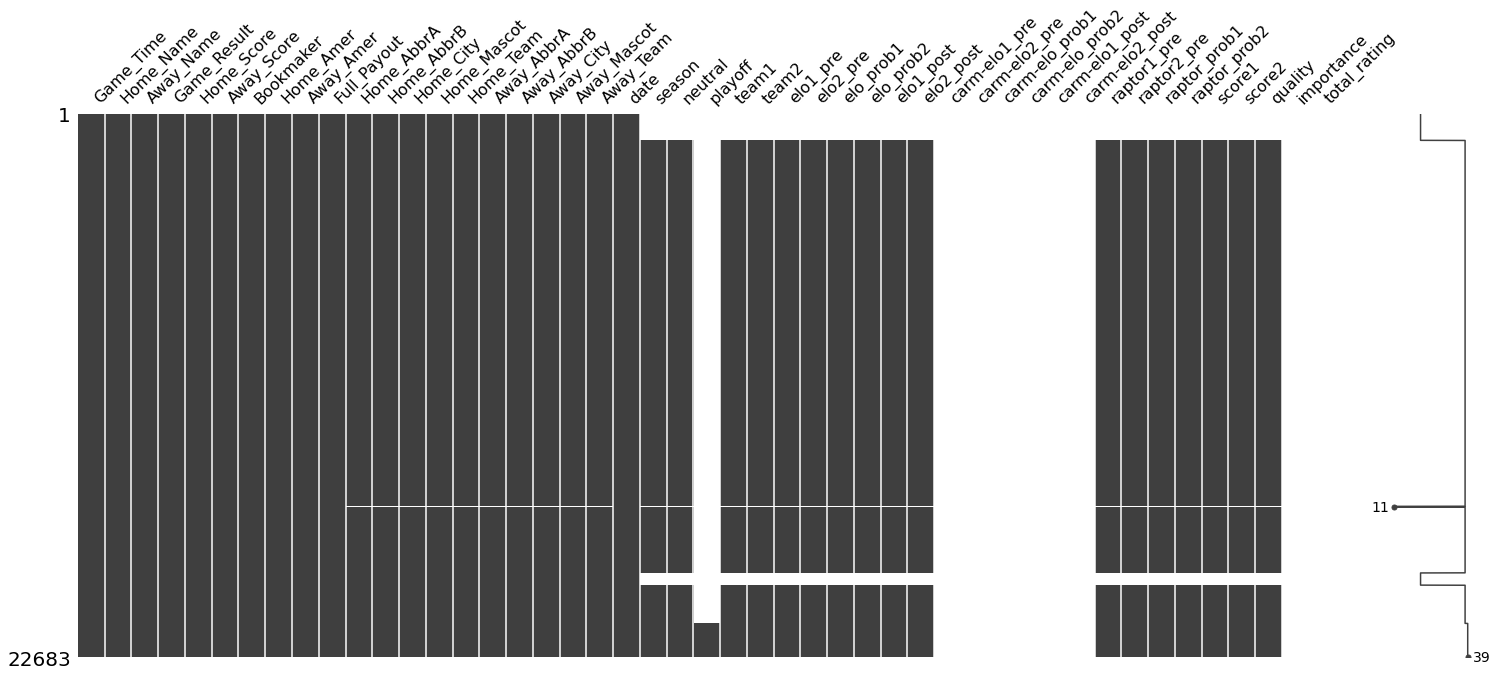

In [20]:
ms.matrix(full);

In [22]:
full = full.dropna(subset=['raptor1_pre','raptor2_pre'])

In [23]:
full.shape

(21016, 47)

### Reorder and Drop Columns and Save to Pickle

In [25]:
full = full[[
    'date','Home_AbbrB','Away_AbbrB','Bookmaker',
    'Home_Amer','Away_Amer',
    'elo1_pre','elo2_pre',
    'elo_prob1','elo_prob2',
    'raptor1_pre','raptor2_pre',
    'raptor_prob1','raptor_prob2',
]]

In [111]:
full.shape

(20889, 21)

In [112]:
full.to_pickle(f'nba-{season}-with-raptor.pkl')